# Figure 5: Condensates Analyses

In [1]:
import met_brewer
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from matplotlib import pyplot as plt
from scipy import stats
from statannotations.Annotator import Annotator

sys.path.append("../")

from plotting import (violinplot_reflected, 
                      table_circle_size_plot, 
                      y2h_ppi_per_tf_gene_plot,
                      m1h_activation_per_tf_gene_plot,
                      mimic_r_boxplot,
                      annotate_pval)
from data_loading import (load_condensate_data, 
                          load_annotated_TFiso1_collection, 
                          load_y2h_isoform_data,
                          load_m1h_activation_data)

PAPER_PRESET = {"style": "ticks", "font": "Helvetica", "context": "paper", 
                "rc": {"font.size":7,"axes.titlesize":7,
                       "axes.labelsize":7, 'axes.linewidth':0.5,
                       "legend.fontsize":6, "xtick.labelsize":6,
                       "ytick.labelsize":6, "xtick.major.size": 3.0,
                       "ytick.major.size": 3.0, "axes.edgecolor": "black",
                       "xtick.major.pad": 3.0, "ytick.major.pad": 3.0}}
PAPER_FONTSIZE = 7

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

In [3]:
np.random.seed(2023)

## functions

In [4]:
# def permutation_test(x, y):
#     """
#     two-sided
#     """
#     nx = x.shape[0]
#     ny = y.shape[0]
#     obs = x.mean() - y.mean()
#     merged = np.concatenate([x, y])
#     rnd = []
#     for _i in range(100000):
#         np.random.shuffle(merged)
#         rnd.append(merged[:nx].mean() - merged[nx:].mean())
#     return (min([sum(r >= obs for r in rnd), sum(r <= obs for r in rnd)]) / len(rnd)) * 2

In [5]:
def permutation_test(sample1, sample2, num_permutations=1000, seed=None, alternative='two-sided'):
    """
    Conduct a permutation test on two samples.

    :param sample1: First sample (array-like)
    :param sample2: Second sample (array-like)
    :param num_permutations: Number of permutations to perform (int)
    :param seed: Seed for random number generator (int)
    :param alternative: Defines the alternative hypothesis. 
                        'two-sided': the distributions are not equal,
                        'less': the distribution of sample1 is less than the distribution of sample2,
                        'greater': the distribution of sample1 is greater than the distribution of sample2
    :return: p-value (float)
    """

    # Ensure reproducibility
    if seed is not None:
        np.random.seed(seed)

    # Combine the samples
    combined = np.concatenate([sample1, sample2])

    # Calculate the observed test statistic
    observed_stat = np.mean(sample1) - np.mean(sample2)

    # Perform the permutations
    count = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        new_sample_1 = combined[:len(sample1)]
        new_sample_2 = combined[len(sample1):]

        # Calculate the new test statistic
        new_stat = np.mean(new_sample_1) - np.mean(new_sample_2)

        # Check if the new test statistic is at least as extreme as the original
        if alternative == 'two-sided':
            count += abs(new_stat) >= abs(observed_stat)
        elif alternative == 'less':
            count += new_stat <= observed_stat
        elif alternative == 'greater':
            count += new_stat >= observed_stat
        else:
            raise ValueError("alternative must be 'two-sided', 'less', or 'greater'")

    # Calculate the p-value
    p_value = (count + 1) / (num_permutations + 1)

    return p_value

## 1. import data

In [6]:
pairs, df = load_condensate_data()

## 2. summary of data

In [7]:
print('successfully tested {} isoforms of {} TF genes'.format(df.index.nunique(),
                    df['gene_symbol'].nunique())
    )
for cl in ['HEK', 'U2OS']:
    print(f'in {cl} cells:')
    print('{} ({:.0%}) reference isoforms show condensates'.format(
        df.loc[df['is_cloned_reference'], f'condensates_observed_{cl}'].sum(),
        df.loc[df['is_cloned_reference'], f'condensates_observed_{cl}'].mean()))
    print('{} ({:.0%}) alternative isoforms show condensates'.format(
        df.loc[~df['is_cloned_reference'], f'condensates_observed_{cl}'].sum(),
        df.loc[~df['is_cloned_reference'], f'condensates_observed_{cl}'].mean()))
    print('{} ({:.0%}) alternative isoforms change condensate formation compared to reference'.format(
        (pairs[f'condensate_cat_{cl}'] != 'Unchanged').sum(),
        (pairs[f'condensate_cat_{cl}'] != 'Unchanged').mean()))

    print()
    print(pairs[f'condensate_cat_{cl}'].value_counts())
    print()

successfully tested 189 isoforms of 60 TF genes
in HEK cells:
47 (78%) reference isoforms show condensates
102 (79%) alternative isoforms show condensates
50 (39%) alternative isoforms change condensate formation compared to reference

Unchanged               79
LOC                     19
GOC                     16
Changed localization    15
Name: condensate_cat_HEK, dtype: int64

in U2OS cells:
49 (82%) reference isoforms show condensates
103 (80%) alternative isoforms show condensates
42 (33%) alternative isoforms change condensate formation compared to reference

Unchanged               87
LOC                     18
Changed localization    15
GOC                      9
Name: condensate_cat_U2OS, dtype: int64



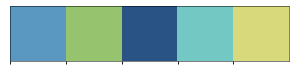

In [8]:
colors = met_brewer.met_brew(name="Hokusai3", n=5, brew_type="discrete")
sns.palplot(colors)

In [9]:
f = pd.concat(
        [pairs['combined_cat_HEK'].value_counts().to_frame().T,
        pairs['combined_cat_U2OS'].value_counts().to_frame().T,]
)
if f.sum(axis=1).nunique() > 1:
    raise UserWarning('expected identical numbers for both cell lines')
f = f / f.sum(axis=1).iloc[0] * 100
f.head()

,Same localization and condensate formation,Difference in localization,Difference in condensate formation,Difference in both
combined_cat_HEK,48.837209,24.031008,16.279070,10.852713
combined_cat_U2OS,51.162791,27.906977,13.953488,6.976744


In [10]:
f.columns = ["Same localization &\ncondensate formation", "∆ localization",
             "∆ condensate formation", "∆ both"]

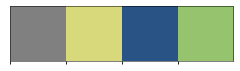

In [11]:
pal = {"Same localization &\ncondensate formation": "grey",
       "∆ localization": colors[4],
       "∆ condensate formation": colors[2],
       "∆ both": colors[1]}
sns.palplot(pal.values())

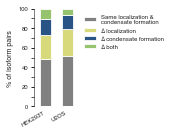

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.8, h=1.8)
f.plot.bar(stacked=True, 
           ax=ax,
           color=pal.values())
for pos in ['top', 'bottom', 'right']:
    ax.spines[pos].set_visible(False)
ax.set_xticklabels(['HEK293T', 'U2OS'], rotation=30, va="top", ha="right")
ax.xaxis.set_tick_params(length=0)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticks(range(0, 101, 10), minor=True)
ax.set_ylabel('% of isoform pairs')
ax.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)
fig.savefig('../../figures/fig5/localization-and-condensate-difference_stacked-bar.pdf',
            bbox_inches='tight')

## 2. ribbon plots to show localization changes

In [13]:
# NOTE: I put this code at the end because it changes the matplotlib defaults
# so messes up the other plots
from pySankey import sankey
import matplotlib.font_manager as font_manager

In [14]:
pairs.loc[pairs['localization_U2OS_alt'].notnull(), 'localization_U2OS_ref']

0         both
1      nucleus
2      nucleus
5      nucleus
6      nucleus
        ...   
431       both
432       both
433       both
438    nucleus
439    nucleus
Name: localization_U2OS_ref, Length: 129, dtype: object

In [15]:
tmp = pairs.copy()
tmp["loc_U2OS_ref_srt"] = pd.Categorical(tmp['localization_U2OS_ref'], ['cytoplasm', 'both', 'nucleus'])
tmp["loc_U2OS_alt_srt"] = pd.Categorical(tmp['localization_U2OS_alt'], ['cytoplasm', 'both', 'nucleus'])
tmp["loc_HEK_ref_srt"] = pd.Categorical(tmp['localization_HEK_ref'], ['cytoplasm', 'both', 'nucleus'])
tmp["loc_HEK_alt_srt"] = pd.Categorical(tmp['localization_HEK_alt'], ['cytoplasm', 'both', 'nucleus'])

tmp = tmp.sort_values(by='loc_U2OS_ref_srt')

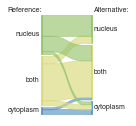

In [16]:
sankey.sankey(left=tmp.loc[tmp['localization_U2OS_alt'].notnull(), 'localization_U2OS_ref'],
              right=tmp.loc[tmp['localization_U2OS_alt'].notnull(), 'localization_U2OS_alt'],
              fontsize=PAPER_FONTSIZE,
              aspect=1.5,
              colorDict={"both": colors[4],
                         "nucleus": colors[1],
                         "cytoplasm": colors[0]})
ax = plt.gca()
fig = plt.gcf()

plt.gca().text(x=-1, y=pairs.shape[0] * 1.05, s='Reference:',
               fontsize=PAPER_FONTSIZE,
               va='bottom',
               ha='right',)
plt.gca().text(x=95, y=pairs.shape[0] * 1.05, s='Alternative:',
               fontsize=PAPER_FONTSIZE,
               va='bottom',
               ha='left',)

# change fonts back to helvetica
font_prop = font_manager.FontProperties(family='Helvetica')
for text in ax.texts:
    text.set_fontproperties(font_prop)

# change figure size
fig.set_size_inches(1, 2)

plt.savefig('../../figures/fig5/localization_ref-vs-alt_U2OS_Sankey.pdf',
            bbox_inches='tight')

In [17]:
tmp = tmp.sort_values(by='loc_HEK_ref_srt')

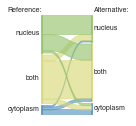

In [18]:
sankey.sankey(left=tmp.loc[tmp['localization_HEK_alt'].notnull(), 'localization_HEK_ref'],
              right=tmp.loc[tmp['localization_HEK_alt'].notnull(), 'localization_HEK_alt'],
              fontsize=PAPER_FONTSIZE,
              aspect=1.5,
              colorDict={"both": colors[4],
                         "nucleus": colors[1],
                         "cytoplasm": colors[0]})
ax = plt.gca()
fig = plt.gcf()

plt.gca().text(x=-1, y=pairs.shape[0] * 1.05, s='Reference:',
               fontsize=PAPER_FONTSIZE,
               va='bottom',
               ha='right',)
plt.gca().text(x=95, y=pairs.shape[0] * 1.05, s='Alternative:',
               fontsize=PAPER_FONTSIZE,
               va='bottom',
               ha='left',)

# change fonts back to helvetica
font_prop = font_manager.FontProperties(family='Helvetica')
for text in ax.texts:
    text.set_fontproperties(font_prop)

# change figure size
fig.set_size_inches(1, 2)

plt.savefig('../../figures/fig5/localization_ref-vs-alt_HEK_Sankey.pdf',
            bbox_inches='tight')

In [19]:
# reset matplotlib params
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## 3. correlation plots to show agreement between cell lines

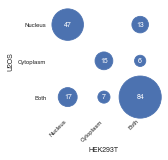

In [20]:
tbl = (df.groupby(['localization_HEK', 'localization_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='localization_HEK',
        columns='localization_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
table_circle_size_plot(tbl, ax=ax, scale=4000, fontsize=PAPER_FONTSIZE)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()])
fig.savefig('../../figures/fig5/localization_HEK-vs-U2OS_diff-cat_circle-plot.pdf', bbox_inches='tight')

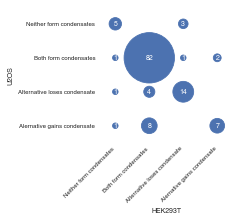

In [21]:
tbl = (pairs.groupby(['condensate_cat_only_detailed_HEK', 'condensate_cat_only_detailed_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='condensate_cat_only_detailed_HEK',
        columns='condensate_cat_only_detailed_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2.5, 2.5)
table_circle_size_plot(tbl, ax=ax, scale=4000, fontsize=PAPER_FONTSIZE)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
fig.savefig('../../figures/fig5/condensate_only_detailed_HEK-vs-U2OS_diff-vs-no_circle-plot.pdf', bbox_inches='tight')

## 4. charts to show distribution of changes

In [22]:
def reword_for_pie_chart(row, col):
    if pd.isnull(row[col]):
        return np.nan
    elif row[col] == "BOTH":
        return "both nuclear/\ncytoplasmic\ncondensates"
    elif row[col] == "CC":
        return "cytoplasmic\ncondensates"
    elif row[col] == "NC":
        return "nuclear\ncondensates"
    else:
        return np.nan
    
df["HEK_Condensate_rw"] = df.apply(reword_for_pie_chart, axis=1, col="HEK_Condensate")
df["U2OS_Condensate_rw"] = df.apply(reword_for_pie_chart, axis=1, col="U2OS_Condensate")

In [23]:
df.loc[df['is_cloned_reference'], f'{cl}_Condensate_rw'].fillna('no\ncondensates').value_counts().sort_index()

both nuclear/\ncytoplasmic\ncondensates    17
cytoplasmic\ncondensates                   12
no\ncondensates                            11
nuclear\ncondensates                       20
Name: U2OS_Condensate_rw, dtype: int64

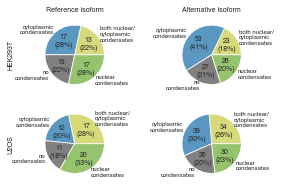

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4.5, 3))
for i, cl in enumerate(['HEK', 'U2OS']):
    n = df['is_cloned_reference'].sum()
    (
        df.loc[df['is_cloned_reference'], f'{cl}_Condensate_rw']
        .fillna('no\ncondensates')
        .value_counts()
        .sort_index()
        .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
    ax=axs[i, 0], colors=[colors[4], colors[0], "grey", colors[1]])
    )
    n = (~df['is_cloned_reference']).sum()
    (
        df.loc[~df['is_cloned_reference'], f'{cl}_Condensate_rw']
        .fillna('no\ncondensates')
        .value_counts()
        .sort_index()
        .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
    ax=axs[i, 1], colors=[colors[4], colors[0], "grey", colors[1]])
    )
axs[0, 0].set_title('Reference isoform')
axs[0, 1].set_title('Alternative isoform')
axs[0, 0].text(s='HEK293T\n\n', x=-1.5, y=0, rotation=90, ha='right', va='center')
axs[1, 0].text(s='U2OS\n\n', x=-1.5, y=0, rotation=90, ha='right', va='center')
for ax in axs.flatten():
    ax.set_ylabel('')
fig.savefig('../../figures/fig5/condensate-localisation_ref-vs-alt_pie.pdf',
            bbox_inches='tight')

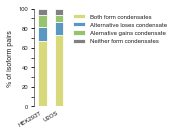

In [25]:
f = pd.concat(
        [pairs['condensate_cat_only_detailed_HEK'].value_counts().to_frame().T,
        pairs['condensate_cat_only_detailed_U2OS'].value_counts().to_frame().T,]
)
if f.sum(axis=1).nunique() > 1:
    raise UserWarning('expected identical numbers for both cell lines')
f = f / f.sum(axis=1).iloc[0] * 100
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.6, h=1.8)
f.plot.bar(stacked=True, 
           ax=ax,
           color=[colors[4], colors[0], colors[1], "grey"])
for pos in ['top', 'bottom', 'right']:
    ax.spines[pos].set_visible(False)
ax.set_xticklabels(['HEK293T', 'U2OS'], rotation=30, va="top", ha="right")
ax.xaxis.set_tick_params(length=0)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticks(range(0, 101, 10), minor=True)
ax.set_ylabel('% of isoform pairs')
ax.legend(bbox_to_anchor=(1, 1), frameon=False)
fig.savefig('../../figures/fig5/condensate-difference_stacked-bar.pdf',
            bbox_inches='tight')

## 5. examine how RNA-seq expression correlates with condensate formation

In [26]:
from data_loading import (load_annotated_TFiso1_collection,
                          load_developmental_tissue_expression_remapped,
                          load_gtex_remapped)

In [27]:
df_gtex, metadata_gtex, genes_gtex = load_gtex_remapped()

exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}

df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

reading from cache


In [28]:
df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_remapped()

rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}

metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

reading from cache


In [29]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)
max_gtex = means_gtex[["max_gtex"]] 

means_dev["max_dev"] = means_dev.max(axis=1)
max_dev = means_dev[["max_dev"]]

max_tpm = max_gtex.join(max_dev)
max_tpm = np.log2(max_tpm+1)
max_tpm = max_tpm.reset_index()
max_tpm["clone_acc"] = max_tpm.UID.str.split(" ", expand=True)[0]

In [30]:
max_tpm["gene_symbol"] = max_tpm["clone_acc"].str.split("|", expand=True)[0]
max_tpm_gene = max_tpm[["gene_symbol", "max_gtex", "max_dev"]]
max_tpm_gene = max_tpm_gene.groupby("gene_symbol")[["max_gtex", "max_dev"]].agg("sum").reset_index()
max_tpm_gene.columns = ["gene_symbol", "max_gtex_gene", "max_dev_gene"]

In [31]:
pairs_exp = pairs.merge(max_tpm[["clone_acc", "max_gtex", 
                             "max_dev"]],
                        left_on="clone_acc_ref", right_on="clone_acc")
pairs_exp.drop("clone_acc", axis=1, inplace=True)
pairs_exp = pairs_exp.merge(max_tpm[["clone_acc", "max_gtex", "max_dev"]],
                    left_on="clone_acc_alt", 
                    right_on="clone_acc",
                    suffixes=("_ref", "_alt"))
pairs_exp.drop("clone_acc", axis=1, inplace=True)
pairs_exp = pairs_exp.merge(max_tpm_gene, on="gene_symbol")
pairs_exp.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,combined_cat_U2OS,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,max_gtex_ref,max_dev_ref,max_gtex_alt,max_dev_alt,max_gtex_gene,max_dev_gene
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,...,Same localization and condensate formation,No difference,BOTH -> NC,BOTH -> BOTH,3.119615,3.402279,2.996788,3.260954,6.116403,6.663233
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,...,Difference in condensate formation,Difference,NC -> None,NC -> None,2.856889,2.835991,2.420840,2.290445,7.489377,7.683716
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,...,Same localization and condensate formation,NaN,NC -> None,NC -> NC,2.856889,2.835991,2.211648,2.557280,7.489377,7.683716
3,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,Difference in localization,NaN,NC -> BOTH,NC -> BOTH,2.902086,1.775482,1.261399,0.907528,7.919554,6.649063
4,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,...,Difference in localization,NaN,NC -> BOTH,NC -> BOTH,2.902086,1.775482,0.544584,0.271218,7.919554,6.649063


In [32]:
to_plot = pd.melt(pairs_exp[["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                         "condensates_observed_HEK_ref", "condensates_observed_U2OS_ref",
                         "max_dev_ref", "max_gtex_ref"]],
                  id_vars=["gene_symbol", "clone_acc_ref", "clone_acc_alt",
                           "max_dev_ref", "max_gtex_ref"])
to_plot = to_plot.drop_duplicates()
print(len(to_plot))
to_plot.head()

254


,gene_symbol,clone_acc_ref,clone_acc_alt,max_dev_ref,max_gtex_ref,variable,value
0,ZBTB18,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,3.402279,3.119615,condensates_observed_HEK_ref,True
1,PRRX1,PRRX1|2/3|09F06,PRRX1|1/3|09C07,2.835991,2.856889,condensates_observed_HEK_ref,True
2,PRRX1,PRRX1|2/3|09F06,PRRX1|3/3|09H08,2.835991,2.856889,condensates_observed_HEK_ref,True
3,GRHL3,GRHL3|3/7|08G09,GRHL3|1/7|08E10,1.775482,2.902086,condensates_observed_HEK_ref,True
4,GRHL3,GRHL3|3/7|08G09,GRHL3|2/7|08A10,1.775482,2.902086,condensates_observed_HEK_ref,True


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 46.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 42.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
../plotting.py:1005: MatplotlibDepre

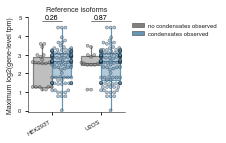

In [33]:
fig = plt.figure(figsize=(1.75, 1.75))

ax = sns.boxplot(data=to_plot, x="variable", hue="value", y="max_dev_ref",
                 palette={False: "grey", True: colors[0]},
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=to_plot, x="variable", hue="value", y="max_dev_ref",
              palette={False: "grey", True: colors[0]},
              edgecolor="black", linewidth=0.5, ax=ax,
              size=3, alpha=0.5, dodge=True)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("")
ax.set_xticklabels(["HEK293T", "U2OS"], rotation=30, ha="right", va="top")
ax.set_ylabel("Maximum log2(gene-level tpm)")
ax.set_title("Reference isoforms")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[0:2], labels=["no condensates observed", "condensates observed"],
           loc=2, bbox_to_anchor=(1.01, 1), facecolor="white", markerscale=1,
           frameon=False)

for i, c in enumerate(["HEK", "U2OS"]):
    x = to_plot[(to_plot["variable"] == "condensates_observed_%s_ref" % c) &
                (to_plot["value"] == False)]["max_dev_ref"].values
    y = to_plot[(to_plot["variable"] == "condensates_observed_%s_ref" % c) &
                (to_plot["value"] == True)]["max_dev_ref"].values
    u, p = stats.mannwhitneyu(x, y, alternative="two-sided")
    annotate_pval(ax, i-0.2, i+0.2, 4.8, 0, 4.8, p, PAPER_FONTSIZE)

ax.set_ylim((-0.1, 5))
fig.savefig("../../figures/fig5/Dev_expr_cond.pdf", dpi="figure", bbox_inches="tight")

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 49.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y]

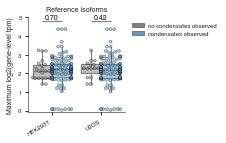

In [34]:
fig = plt.figure(figsize=(1.75, 1.75))

ax = sns.boxplot(data=to_plot, x="variable", hue="value", y="max_gtex_ref",
                 palette={False: "grey", True: colors[0]},
                 fliersize=0)
mimic_r_boxplot(ax)
sns.swarmplot(data=to_plot, x="variable", hue="value", y="max_gtex_ref",
              palette={False: "grey", True: colors[0]},
              edgecolor="black", linewidth=0.5, ax=ax,
              size=3, alpha=0.5, dodge=True)

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("")
ax.set_xticklabels(["HEK293T", "U2OS"], rotation=30, ha="right", va="top")
ax.set_ylabel("Maximum log2(gene-level tpm)")
ax.set_title("Reference isoforms")

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[0:2], labels=["no condensates observed", "condensates observed"],
           loc=2, bbox_to_anchor=(1.01, 1), facecolor="white", markerscale=1,
           frameon=False)

for i, c in enumerate(["HEK", "U2OS"]):
    x = to_plot[(to_plot["variable"] == "condensates_observed_%s_ref" % c) &
                (to_plot["value"] == False)]["max_gtex_ref"].values
    y = to_plot[(to_plot["variable"] == "condensates_observed_%s_ref" % c) &
                (to_plot["value"] == True)]["max_gtex_ref"].values
    u, p = stats.mannwhitneyu(x, y, alternative="two-sided")
    annotate_pval(ax, i-0.2, i+0.2, 4.8, 0, 4.8, p, PAPER_FONTSIZE)

ax.set_ylim((-0.1, 5))
fig.savefig("../../figures/fig5/GTEx_expr_cond.pdf", dpi="figure", bbox_inches="tight")

## 6. examine how our localizations compare to HPA

In [35]:
hpa = pd.read_table("../../data/external/HPA_subcellular_location.tsv", sep="\t")
hpa["all_observed"] = hpa["Approved"].astype(str) + ";" + hpa["Enhanced"].astype(str) + ";" + hpa["Supported"].astype(str) + ";" + hpa["Uncertain"].astype(str)
hpa.head()

,Gene,Gene name,Reliability,Main location,Additional location,Extracellular location,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id,all_observed
0,ENSG00000000003,TSPAN6,Approved,Cell Junctions;Cytosol,Nucleoli fibrillar center,NaN,NaN,NaN,Cell Junctions;Cytosol;Nucleoli fibrillar center,NaN,Cytosol,NaN,NaN,Cell Junctions (GO:0030054);Cytosol (GO:000582...,Cell Junctions;Cytosol;Nucleoli fibrillar cent...
1,ENSG00000000457,SCYL3,Supported,Cytosol;Golgi apparatus,NaN,NaN,NaN,Cytosol;Golgi apparatus,NaN,NaN,NaN,NaN,NaN,Cytosol (GO:0005829);Golgi apparatus (GO:0005794),nan;nan;Cytosol;Golgi apparatus;nan
2,ENSG00000000460,C1orf112,Approved,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria (GO:0005739),Mitochondria;nan;nan;nan
3,ENSG00000000938,FGR,Approved,Plasma membrane,Aggresome,NaN,NaN,NaN,Aggresome;Plasma membrane,NaN,NaN,NaN,NaN,Aggresome (GO:0016235);Plasma membrane (GO:000...,Aggresome;Plasma membrane;nan;nan;nan
4,ENSG00000000971,CFH,Approved,Vesicles,NaN,Predicted to be secreted,NaN,NaN,Vesicles,NaN,NaN,NaN,NaN,Vesicles (GO:0043231),Vesicles;nan;nan;nan


In [36]:
def cytosolic_loc(row, col):
    cytosolic_locs_to_consider = ["Actin filaments", "Cleavage furrow", "Focal adhesion sites",
                                  "Intermediate filaments", "Centriolar satellite", "Centrosome",
                                  "Cytokinetic bridge", "Microtubule ends", "Microtubules",
                                  "Midbody", "Midbody ring", "Mitotic spindle",
                                  "Aggresome", "Cytoplasmic bodies", "Cytosol", "Rods & rings",
                                  "Mitochondria", "Endoplasmic reticulum", "Vesicles",
                                  "Endosomes", "Lipid droplets", "Lysosomes", "Peroxisomes",
                                  "Golgi apparatus", "Cell junctions", "Plasma membrane"]
    
    for loc in cytosolic_locs_to_consider:
        if loc in str(row[col]):
            return True
    return False

hpa["cyto_observed"] = hpa.apply(cytosolic_loc, col="all_observed", axis=1)
len(hpa[hpa["cyto_observed"] == True]["Gene name"].unique())

10043

In [37]:
hpa["cyto_observed_approved"] = hpa.apply(cytosolic_loc, col="Approved", axis=1)
len(hpa[hpa["cyto_observed_approved"] == True]["Gene name"].unique())

5872

In [38]:
pairs_hpa = pairs.merge(hpa, left_on="gene_symbol", right_on="Gene name", how="left")
pairs_hpa.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,...,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id,all_observed,cyto_observed,cyto_observed_approved
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,...,Nuclear speckles;Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nuclear speckles (GO:0016607);Nucleoplasm (GO:...,nan;nan;Nuclear speckles;Nucleoplasm;nan,False,False
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,...,Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),nan;nan;Nucleoplasm;nan,False,False
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,...,Nucleoplasm,NaN,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),nan;nan;Nucleoplasm;nan,False,False
3,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,...,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),Nucleoplasm;nan;nan;nan,False,False
4,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|2/7|08A10,ENST00000361548,ENST00000236255,False,False,...,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654),Nucleoplasm;nan;nan;nan,False,False


In [39]:
pairs_hpa.localization_HEK_ref.value_counts()

both         66
nucleus      51
cytoplasm    12
Name: localization_HEK_ref, dtype: int64

In [40]:
dd = pairs_hpa[["gene_symbol", "clone_acc_ref",
            "localization_HEK_ref",
            "localization_U2OS_ref",
            "Approved",
            "cyto_observed_approved",
            "all_observed",
            "cyto_observed"]].drop_duplicates()

percs = pd.DataFrame()
for c in ["HEK", "U2OS"]:
    tot = dd.groupby("localization_%s_ref" % c)["clone_acc_ref"].agg("count").reset_index()
    cyto = dd[dd["cyto_observed"] == True].groupby(["localization_%s_ref" % c])["clone_acc_ref"].agg("count").reset_index()
    cyto_perc = tot.merge(cyto, on="localization_%s_ref" % c)
    cyto_perc.columns = ["localization_ref", "tot", "cyto_observed"]
    cyto_perc["cell_line"] = c
    cyto_perc["perc_cyto_observed"] = cyto_perc["cyto_observed"]/cyto_perc["tot"]*100
    percs = percs.append(cyto_perc)

percs

,localization_ref,tot,cyto_observed,cell_line,perc_cyto_observed
0,both,30,13,HEK,43.333333
1,cytoplasm,6,5,HEK,83.333333
2,nucleus,24,8,HEK,33.333333
0,both,29,13,U2OS,44.827586
1,cytoplasm,5,4,U2OS,80.000000
2,nucleus,26,9,U2OS,34.615385


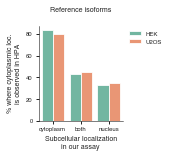

In [41]:
fig = plt.figure(figsize=(1.5, 1.75))

ax = sns.barplot(data=percs, x="localization_ref", y="perc_cyto_observed", hue="cell_line",
                 palette=sns.color_palette("Set2"), order=["cytoplasm", "both", "nucleus"])

for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
    
ax.set_xlabel("Subcellular localization\nin our assay")
ax.set_ylabel("% where cytoplasmic loc.\nis observed in HPA")
ax.set_title("Reference isoforms\n")

plt.legend(loc=2, bbox_to_anchor=(1.01, 1), frameon=False)


fig.savefig("../../figures/fig5/hpa.pdf", dpi="figure", bbox_inches="tight")

## 7. examine how PDIs/PPIs/activ diffs correlate with condensate/loc diffs

In [42]:
def Welchs_t_statistic(x, y):
    denom = np.sqrt(x.var() / len(x) + y.var() / len(y))
    return (x.mean() - y.mean()) / denom


def permutation_test(x, y):
    """
    two-sided
    """
    nx = x.shape[0]
    ny = y.shape[0]
    #obs = x.mean() - y.mean()
    obs = Welchs_t_statistic(x, y)
    merged = np.concatenate([x, y])
    rnd = []
    np.random.seed(2023)
    for _i in range(10000):
        np.random.shuffle(merged)
        #rnd.append(merged[:nx].mean() - merged[nx:].mean())
        rnd.append(Welchs_t_statistic(merged[:nx], merged[nx:]))
    return (min([sum(r >= obs for r in rnd), sum(r <= obs for r in rnd)]) / len(rnd)) * 2

In [43]:
def condensate_violin_plot(var, cl, xvar='condensate_cat_merged', ub=1, bw=0.1,
                           draw_mean=False, xlabel='Condensate formation between reference and alternative',
                           set_axis=True, p_height=1.05, fig_height=2):
    x = pairs.loc[(pairs[f'{xvar}_{cl}'] == 'No difference')
                & pairs[var].notnull(), 
                var].values
    y = pairs.loc[(pairs[f'{xvar}_{cl}'] == 'Difference')
                & pairs[var].notnull(), 
                var].values

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(w=2, h=fig_height)
    sns.swarmplot(data=pairs,
                        x=f'{xvar}_{cl}',
                        y=var,
                order=['No difference', 'Difference'],
                color='white',
                  edgecolor='black',
                  linewidth=0.5,
                ax=ax,
                clip_on=False,
                 size=4)
    violinplot_reflected(data=pairs,
                        x=f'{xvar}_{cl}',
                        y=var,
                        inner=None,
                        ub=ub,
                        bw_const=bw,
                cut=0,
                color=colors[0],
                order=['No difference', 'Difference'],
                ax=ax,
                )
    if draw_mean:
        sns.pointplot(data=pairs,
                      x=f'{xvar}_{cl}',
                      y=var,
                      )
    ax.set_ylim(0, 1 if ub == 1 else None)

    pval = permutation_test(x, y)
    annotate_pval(ax, 0.1, 0.9, p_height, 0, p_height, pval, PAPER_FONTSIZE)
    
    # manually set left axis so it stops at 1.0
    if set_axis == True:
        ax.set_ylim((-0.1, 1.2))
        ax.spines['left'].set_visible(False)
        ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
        axes_to_data = ax.transAxes + ax.transData.inverted()
        left_spine_in_data_coords = axes_to_data.transform((0, 0))
        ax.plot([left_spine_in_data_coords[0], left_spine_in_data_coords[0]], [0, 1],
                 color=ax.spines['bottom'].get_edgecolor(), linewidth=ax.spines['bottom'].get_linewidth())
        ax.tick_params(axis='x', which='major', pad=-5)

    ax.set_xlabel(xlabel)
    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel(
        {'activation_abs_fold_change_log2': '|Activation log2FC|',
        'PPI_Jaccard_d': 'PPI Jaccard distance',
        'PDI_Jaccard_d': 'PDI Jaccard distance',
        }.get(var, var)
 )
    ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                        'Difference\n(N = {})'.format(y.shape[0])])
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../../figures/fig5/{var}-vs-{xvar}_{cl}_violinplot.pdf',
                bbox_inches='tight')

In [44]:
pairs.groupby(['condensate_or_loc_change_HEK', 
               'condensate_or_loc_change_U2OS']).size()

condensate_or_loc_change_HEK  condensate_or_loc_change_U2OS
Difference                    Difference                       49
                              No difference                    17
No difference                 Difference                       14
                              No difference                    49
dtype: int64

../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


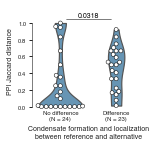

In [45]:
condensate_violin_plot(var='PPI_Jaccard_d', 
                       cl='both', 
                       xvar='condensate_or_loc_change', 
                       draw_mean=False,
                       xlabel='Condensate formation and localization\nbetween reference and alternative',
                       )

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


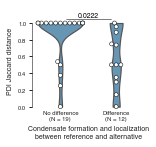

In [46]:
condensate_violin_plot(var='PDI_Jaccard_d',
                       cl='both',
                       xvar='condensate_or_loc_change',
                       draw_mean=False,
                       xlabel='Condensate formation and localization\nbetween reference and alternative',
)

In [47]:
pairs["activation_abs_fold_change_log2"] = np.abs(pairs["activation_fold_change_log2"])

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 12.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
../plotting.py:1005: MatplotlibDeprecationWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1, c="black", linewidth=0.5)


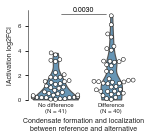

In [48]:
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='both',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_or_loc_change',
                       draw_mean=False,
                       xlabel='Condensate formation and localization\nbetween reference and alternative',
                       set_axis=False,
                       p_height=7,
                       fig_height=1.65,
                       )

## 8. PBX1 & FOXP2 vignettes

In [49]:
tfs = load_annotated_TFiso1_collection()

reading from cache


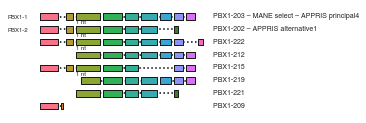

In [50]:
fig, ax = plt.subplots(figsize=(3.25, 2))

tfs["PBX1"].exon_diagram(ax=ax)
fig.savefig("../../figures/fig5/{}_exon_diagram.pdf".format("PBX1"), bbox_inches="tight", dpi="figure")

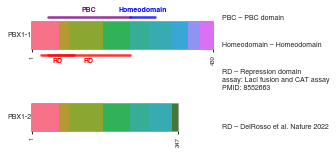

In [51]:
fig, ax = plt.subplots(figsize=(3.25, 2))

tfs["PBX1"].protein_diagram(ax=ax, only_cloned_isoforms=True)
fig.savefig("../../figures/fig5/{}_protein_diagram.pdf".format("PBX1"), bbox_inches="tight", dpi="figure")

In [52]:
y2h = load_y2h_isoform_data()
m1h = load_m1h_activation_data(add_missing_data=True)

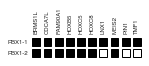

In [53]:
tf = tfs["PBX1"]
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
y2h_ppi_per_tf_gene_plot(tf.name, ax=ax, data=y2h)
plt.savefig('../../figures/fig5/{}_y2h-profile.pdf'.format("PBX1"), bbox_inches='tight')

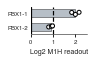

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(1, 0.5))

df = m1h_activation_per_tf_gene_plot("PBX1", data=m1h, ax=ax, xlim=(0, 2.5))
plt.savefig('../../figures/fig5/{}_m1h-profile.pdf'.format("PBX1"), bbox_inches='tight')

## 9. NLS analysis

In [55]:
# look at NLS and NES
nls = pd.concat(tf.aa_feature_disruption(tf.cloned_reference_isoform.name) for tf in tfs.values())
nls = nls.loc[nls['category'] == 'UniProt motif', :]
nls['clone_acc_alt'] = nls['alt_iso'].map(
    {iso.name: iso.clone_acc 
     for tf in tfs.values() 
     for iso in tf.cloned_isoforms}
    )
nls['type'] = nls['accession'].apply(lambda x: x.split('_')[0])
nls['affected'] = (nls['deletion'] + nls['insertion'] + nls['frameshift']) > 0 
pairs['NLS_affected'] = pairs['clone_acc_alt'].map(
    nls.loc[nls['type'] == 'NLS', :]
    .groupby('clone_acc_alt')
    ['affected']
    .any()
    )
pairs['NES_affected'] = pairs['clone_acc_alt'].map(
    nls.loc[nls['type'] == 'NES', :]
    .groupby('clone_acc_alt')
    ['affected']
    .any()
    )

In [56]:
pairs['NLS_affected'].value_counts()

True     8
False    6
Name: NLS_affected, dtype: int64

In [57]:
pairs.loc[pairs['NLS_affected'].notnull(), 'gene_symbol'].value_counts()

KLF7    6
MAX     5
ZIC3    2
TP53    1
Name: gene_symbol, dtype: int64

In [58]:
pairs.loc[pairs['NES_affected'].notnull(), 'gene_symbol'].value_counts()

ATF2    5
TP53    1
Name: gene_symbol, dtype: int64

In [59]:
pairs['NES_affected'].value_counts()

True     5
False    1
Name: NES_affected, dtype: int64

In [60]:
pairs.loc[pairs['NLS_affected'].notnull(),
          ['clone_acc_alt',
           'NLS_affected',
           'NES_affected',
           'HEK_Condensate_ref', 'HEK_Condensate_alt',
           'condensate_cat_HEK',
           'localization_HEK_ref', 'localization_HEK_alt']].sort_values('NLS_affected')

,clone_acc_alt,NLS_affected,NES_affected,HEK_Condensate_ref,HEK_Condensate_alt,condensate_cat_HEK,localization_HEK_ref,localization_HEK_alt
61,KLF7|3/8|10B10,False,NaN,CC,BOTH,Unchanged,both,both
62,KLF7|4/8|10E10,False,NaN,CC,BOTH,Unchanged,both,both
274,MAX|2/6|07F12,False,NaN,NaN,NC,GOC,nucleus,nucleus
337,TP53|2/2|02F03,False,False,BOTH,BOTH,Unchanged,both,both
438,ZIC3|1/3|09F05,False,NaN,NaN,NC,GOC,nucleus,nucleus
439,ZIC3|3/3|09C04,False,NaN,NaN,CC,GOC,nucleus,both
63,KLF7|5/8|11H02,True,NaN,CC,CC,Unchanged,both,both
64,KLF7|6/8|01D06,True,NaN,CC,BOTH,Unchanged,both,both
65,KLF7|7/8|10H08,True,NaN,CC,BOTH,Unchanged,both,both
66,KLF7|8/8|10D09,True,NaN,CC,CC,Unchanged,both,both


In [61]:
pairs.loc[pairs['NLS_affected'].notnull(), ].groupby(['NLS_affected', 'localization_cat_HEK']).size()

NLS_affected  localization_cat_HEK
False         Difference              1
              No difference           5
True          Difference              4
              No difference           4
dtype: int64

In [62]:
pairs.loc[pairs['NLS_affected'].notnull(), ].groupby(['NLS_affected', 'localization_cat_U2OS']).size()

NLS_affected  localization_cat_U2OS
False         Difference               3
              No difference            3
True          Difference               2
              No difference            6
dtype: int64

              NLS preserved  NLS removed  No annotated NLS
NLS_affected              5            4                75
NLS_affected              1            4                40


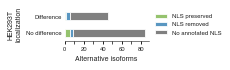

In [63]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=0.6)

data = pd.concat([(pairs.loc[pairs['localization_cat_HEK'] == x, 'NLS_affected'].value_counts(dropna=False)
                    .sort_index()
                    .to_frame()
                    .T)
                    for x in ['No difference', 'Difference']])
data.columns = data.columns.map({np.nan: 'No annotated NLS',
                             False: 'NLS preserved',
                             True: 'NLS removed',
                             })
print(data)
data.plot.barh(stacked=True,
              ax=ax,
              color=[colors[1], colors[0], "grey"])

for pos in ['top', 'left', 'right']:
    ax.spines[pos].set_visible(False)
ax.yaxis.set_tick_params(length=0)

ax.set_yticklabels(['No difference', 'Difference'] * 2)
ax.set_ylabel('HEK293T\nlocalization')
ax.set_xticks(range(0, 81, 20))
ax.set_xticks(range(0, 81, 10), minor=True)
ax.set_xlabel('Alternative isoforms')
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False)



fig.savefig('../../figures/fig5/HEK-NLS-annotation_stacked-bar.pdf',
            bbox_inches='tight')

              NLS preserved  NLS removed  No annotated NLS
NLS_affected              3            6                75
NLS_affected              3            2                40


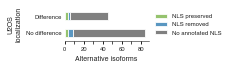

In [64]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=0.6)

data = pd.concat([(pairs.loc[pairs['localization_cat_U2OS'] == x, 'NLS_affected'].value_counts(dropna=False)
                    .sort_index()
                    .to_frame()
                    .T)
                    for x in ['No difference', 'Difference']])
data.columns = data.columns.map({np.nan: 'No annotated NLS',
                             False: 'NLS preserved',
                             True: 'NLS removed',
                             })
print(data)
data.plot.barh(stacked=True,
              ax=ax,
              color=[colors[1], colors[0], "grey"])

for pos in ['top', 'left', 'right']:
    ax.spines[pos].set_visible(False)
ax.yaxis.set_tick_params(length=0)

ax.set_yticklabels(['No difference', 'Difference'] * 2)
ax.set_ylabel('U2OS\nlocalization')
ax.set_xticks(range(0, 81, 20))
ax.set_xticks(range(0, 81, 10), minor=True)
ax.set_xlabel('Alternative isoforms')
ax.legend(loc="upper left", bbox_to_anchor=(1.01, 1), frameon=False)



fig.savefig('../../figures/fig5/U2OS-NLS-annotation_stacked-bar.pdf',
            bbox_inches='tight')